In [1]:
import os
import sys

import numpy as np
import pandas as pd
from datetime import datetime
import pdb
import xarray as xr
import matplotlib.pyplot as plt
import puv

import solo

sys.path.append(r'c:\checkouts\python\TUD-COASTAL\python')

In [2]:
dataFolder="ps_data/tailored/"

ds1 = xr.open_dataset(dataFolder+"ps1.nc")
ds2 = xr.open_dataset(dataFolder+"ps2.nc")
ds3 = xr.open_dataset(dataFolder+"ps3.nc")
ds4 = xr.open_dataset(dataFolder+"ps4.nc")
ds5 = xr.open_dataset(dataFolder+"ps5.nc")
ds6 = xr.open_dataset(dataFolder+"ps6.nc")

# ds1 = ds1.dropna(dim='t')

display(ds1)

<xarray.Dataset>
Dimensions:         (f: 128, t: 245)
Coordinates:
  * f               (f) float64 0.0 0.03125 0.0625 0.09375 ... 3.906 3.938 3.969
  * t               (t) datetime64[ns] 2023-09-23T10:09:32 ... 2023-09-29T11:...
Data variables: (12/14)
    zi              (t) float64 ...
    zb              (t) float64 ...
    sf              float64 ...
    name            object ...
    h               (t) float64 ...
    vy              (t, f) float64 ...
    ...              ...
    Tp              (t) float64 ...
    Tm01            (t) float64 ...
    Tm02            (t) float64 ...
    Tmm10           (t) float64 ...
    Tps             (t) float64 ...
    GoProAvailable  (t) float64 ...
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      ps1
    instrument:                ps1
    instrument type:           Ruskin RBR Solo
    instrument serial number:  202438
    epsg:                      28992
    ...                        ...
    summary:                   Hydraulic fieldwork pressure data, with pressu...
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     10-Nov-2023 (15:13:47)
    version:                   v1
    version comments:          constructed with xarray

### Calculate Ursell number
The Ursell number is calculated as a measure for non-linearity. The Tm-1,0 is used (same as Ruessink et al., 2012) in the dispersion relation to find k.

In [3]:
def add_k_and_Ur_to_ds(ds):
    """
    This function adds k and the Ursell number to the dataset as a timeseries. k is calculated using the dispersion relation
    with for Tm-1,0. Ur is calculated as Ur = 3/8 * Hm0 * k / (kh)**3.
    
    Attributes are also added.
    """

    ds = ds.assign({'p_k':('t', puv.disper(w=2*np.pi/ds['Tmm10'], h=ds['h'], g=9.81))})
    ds['p_Ur'] = 3/8 * ds['Hm0'] * ds['p_k'] / (ds['p_k']*ds['h'])**3

    ds['p_k'].attrs = {'units': '1/m', 'long_name': 'wave number',
                       'computation': 'computation based on dispersion relation with Tm-1,0',
                         'comment': 'calculated from pressure data'}
    ds['p_Ur'].attrs = {'units': '-', 'long_name': 'Ursell number',
                       'computation': 'computation based on dispersion relation with Tm-1,0',
                         'comment': 'calculated from pressure data'}
    return ds

ds1 = add_k_and_Ur_to_ds(ds1)
ds2 = add_k_and_Ur_to_ds(ds2)
ds3 = add_k_and_Ur_to_ds(ds3)
ds4 = add_k_and_Ur_to_ds(ds4)
ds5 = add_k_and_Ur_to_ds(ds5)
ds6 = add_k_and_Ur_to_ds(ds6)

In [4]:
# ### Which spectral period?
# Tm-1,0


# ### What to do with depth?
# Linearly interpolate

# ### Pressure asymmetry or velocity asymmetry?
# Probably just stick to pressure asymmetry

# # plt.plot(ds6.sel({'t':'2023-09-29T01:50:00.000000000'}).f, ds6.sel({'t':'2023-09-29T01:50:00.000000000'}).vy)

### Calculate Skewness and Asymmetry
First we load the pressure data. Then de skewness and asymmetry are calculated (per burst).

In [5]:
dataFolder = "ps_data/atm_pressure_removed/"

dsp1 = xr.open_dataset(dataFolder + 'ps1' + '.nc')
dsp2 = xr.open_dataset(dataFolder + 'ps2' + '.nc')
dsp3 = xr.open_dataset(dataFolder + 'ps3' + '.nc')
dsp4 = xr.open_dataset(dataFolder + 'ps4' + '.nc')
dsp5 = xr.open_dataset(dataFolder + 'ps5' + '.nc')
dsp6 = xr.open_dataset(dataFolder + 'ps6' + '.nc')

dsp1 = dsp1.dropna(dim='t')
dsp2 = dsp2.dropna(dim='t')
dsp3 = dsp3.dropna(dim='t')
dsp4 = dsp4.dropna(dim='t')
dsp5 = dsp5.dropna(dim='t')
dsp6 = dsp6.dropna(dim='t')

In [6]:
def add_Sk_As_sig_to_ds(ds, dsp):
    """
    This function adds (pressure) skewness, asymmetry and sig to the given dataset. Atmospheric pressure has been removed
    from the pressure data.
    
    Relevant attributes are added.
    """
    data = []
    for t in dsp.t:
        Sk, As, sig = puv.compute_SkAs(dsp.sel(t=t).sf, dsp.sel(t=t).p)
        Sk = Sk / sig**3
        As = As / sig**3  # Close to shore, As should be negative
        
        data.append((Sk, As, sig))

    data = np.array(data)
    dsp = dsp.assign({'p_Sk':('t', data[:,0]), 'p_As':('t', data[:,1]), 'p_sig':('t', data[:,2])}).drop(['zb', 'zi'])

    ds = ds.merge(dsp, fill_value=np.NAN)
    ds = ds.drop_dims('N')
    
    ds['p_Sk'].attrs =  {'units': '-', 'long_name': 'pressure skewness',
                       'computation': 'computation based on pressure data with atmospheric pressure removed'}
    ds['p_As'].attrs =  {'units': '-', 'long_name': 'pressure asymmetry',
                       'computation': 'computation based on pressure data with atmospheric pressure removed'}
    ds['p_sig'].attrs = {'units': 'm', 'long_name': 'standard deviation',
                       'computation': 'computation based on pressure data with atmospheric pressure removed',
                        'comment': 'this value was used to normalize the Sk and As'}
    return ds

ds1 = add_Sk_As_sig_to_ds(ds1, dsp1)
ds2 = add_Sk_As_sig_to_ds(ds2, dsp2)
ds3 = add_Sk_As_sig_to_ds(ds3, dsp3)
ds4 = add_Sk_As_sig_to_ds(ds4, dsp4)
ds5 = add_Sk_As_sig_to_ds(ds5, dsp5)
ds6 = add_Sk_As_sig_to_ds(ds6, dsp6)



In [7]:
ncOutFile = "ps_data/tailored_with_ps_UrSkAs/"

ds1.to_netcdf(ncOutFile + f'{ds1.instrument}' + '.nc')
ds2.to_netcdf(ncOutFile + f'{ds2.instrument}' + '.nc')
ds3.to_netcdf(ncOutFile + f'{ds3.instrument}' + '.nc')
ds4.to_netcdf(ncOutFile + f'{ds4.instrument}' + '.nc')
ds5.to_netcdf(ncOutFile + f'{ds5.instrument}' + '.nc')
ds6.to_netcdf(ncOutFile + f'{ds6.instrument}' + '.nc')

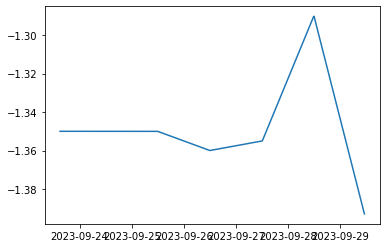

In [8]:
plt.plot(ds6.t, ds6.zb)

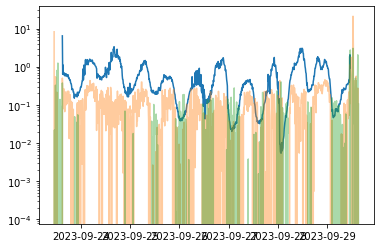

In [9]:
plt.plot(ds6.t, ds6.p_Ur)
plt.plot(ds6.t, ds6.p_Sk, alpha=0.4)
plt.plot(ds6.t, ds6.p_As, alpha=0.4)
plt.yscale('log')

In [10]:
display(ds1)

<xarray.Dataset>
Dimensions:         (t: 894, f: 128)
Coordinates:
  * t               (t) datetime64[ns] 2023-09-23T10:09:32 ... 2023-09-29T14:...
  * f               (f) float64 0.0 0.03125 0.0625 0.09375 ... 3.906 3.938 3.969
Data variables: (12/19)
    zi              (t) float64 0.377 nan nan nan nan ... nan nan nan nan nan
    zb              (t) float64 0.227 nan nan nan nan ... nan nan nan nan nan
    sf              float64 8.0
    name            <U3 'ps1'
    h               (t) float64 0.216 nan nan nan nan ... nan nan nan nan nan
    vy              (t, f) float64 0.0 0.001112 2.794e-05 ... nan nan nan
    ...              ...
    GoProAvailable  (t) float64 0.0 nan nan nan nan nan ... nan nan nan nan nan
    p_k             (t) float64 0.481 nan nan nan nan ... nan nan nan nan nan
    p_Ur            (t) float64 0.816 nan nan nan nan ... nan nan nan nan nan
    p_Sk            (t) float64 -1.892 1.165 3.503 ... -0.5082 0.8212 -0.2343
    p_As            (t) float64 -1.177 1.187 -1.669 ... 0.3732 -1.259 0.3784
    p_sig           (t) float64 108.5 4.796 4.653 19.17 ... 3.395 4.987 3.107
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      ps1
    instrument:                ps1
    instrument type:           Ruskin RBR Solo
    instrument serial number:  202438
    epsg:                      28992
    ...                        ...
    summary:                   Hydraulic fieldwork pressure data, with pressu...
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     10-Nov-2023 (15:13:47)
    version:                   v1
    version comments:          constructed with xarray